# Recurrent Logistic Regression
<font color='darkblue'>This notebook will go through all four steps in the workflow.</font>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Step1: Select overlapping immune-related genes across platforms

In [3]:
df = pd.read_csv("immune related genes.csv")
immune_genes = set(df["Gene Name"].values)
df = pd.read_csv("data/exp.gene.mRNA.GSE57065.csv",index_col=0)
plat1= set(df.index.values)
df = pd.read_csv("data/exp.gene.mRNA.GSE65682.csv",index_col=0)
plat2= set(df.index.values)
df = pd.read_csv("data/exp.gene.mRNA.GSE1548.csv",index_col=0)
plat3=set(df.index.values)

immune_genes = immune_genes & plat1 & plat2 & plat3

## Step 2. Model training

In [4]:
from sklearn.linear_model import LogisticRegression

In [5]:
Y = np.array(pd.read_csv("label/label_GSE57065.csv",index_col=0))
data =  pd.read_csv("data/exp.gene.mRNA.GSE57065.csv",index_col=0).loc[immune_genes]
X=np.array(data).T
ind = np.array(range(X.shape[1]))
C = 0.83
while 1:
    model_logit = LogisticRegression(solver='liblinear')
    results = model_logit.fit(X,Y.ravel())
    coef = results.coef_.flatten()
    removed = np.argwhere(np.abs(coef)<(C*np.sum(np.abs(coef))/coef.shape[0])).flatten()
    if removed.shape[0]==0:
        break
    else:
        ind=np.delete(ind,removed,axis=0)
        X=np.delete(X,removed,axis=1)

In [6]:
markers = data.iloc[ind].index
print(markers)

Index(['LRRN3', 'FCER1A', 'IL2RB', 'S100A12', 'TLR5'], dtype='object')


## Step 4. Performance comparison

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

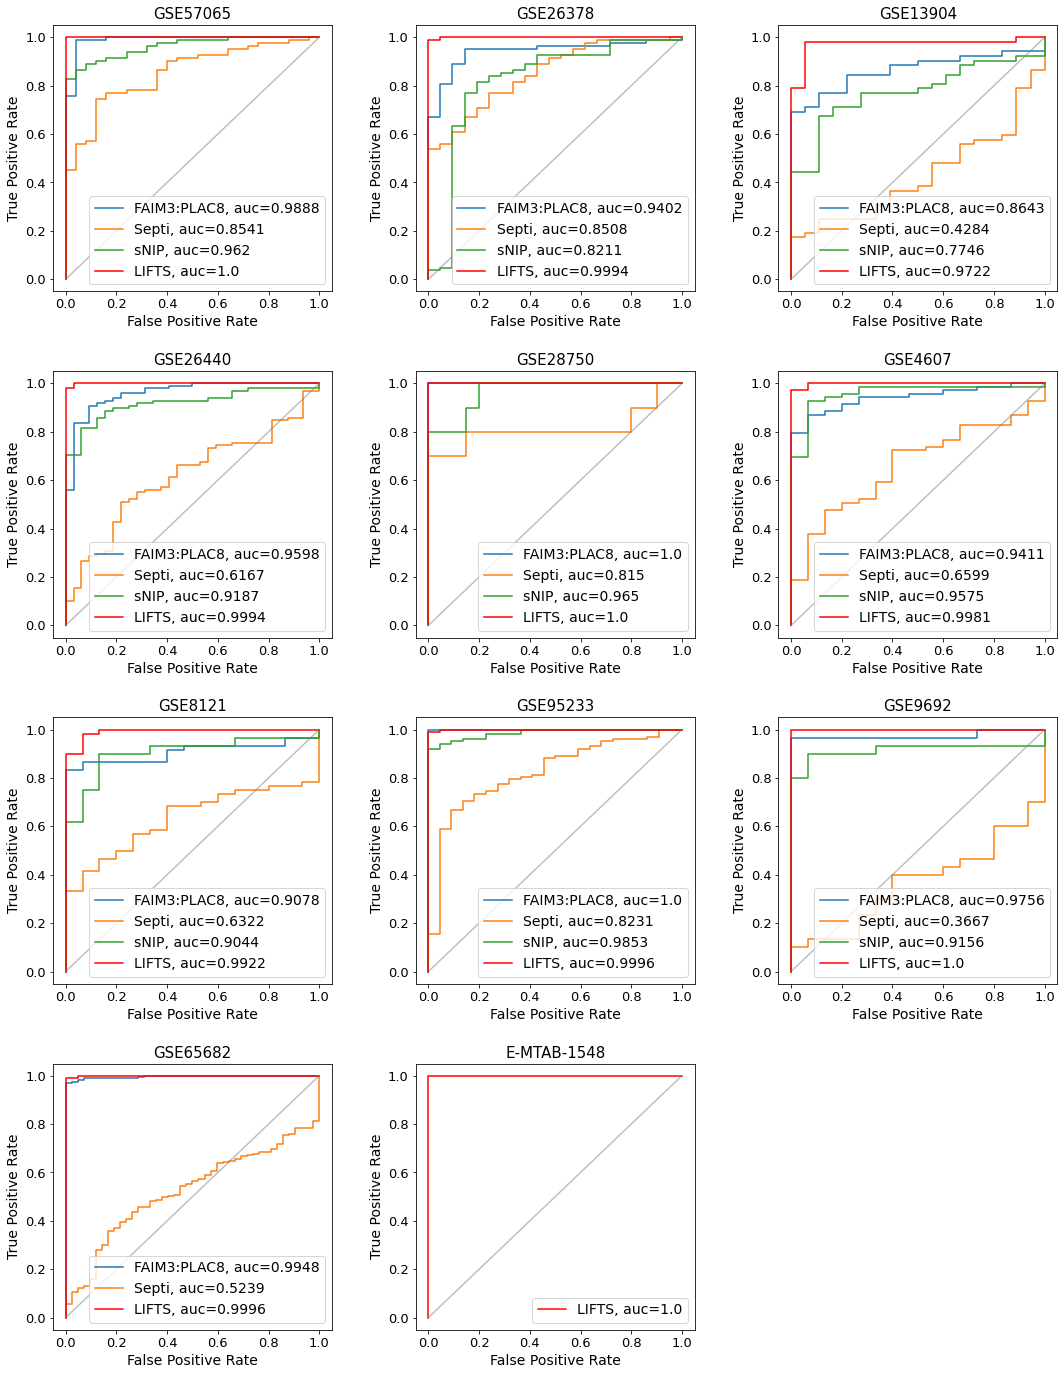

In [7]:
fig = plt.figure(figsize=(18,24))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
WIDTH =None
FONTSIZE = 15
for index,data_set in enumerate(['57065','26378','13904','26440','28750','4607',
                            '8121','95233','9692','65682','1548']):
    fig.add_subplot(4,3,index+1)
    
    y = np.array(pd.read_csv("label/label_GSE"+data_set+".csv",index_col=0))
    valid = np.where(y<2)[0].tolist()
    y = y[valid]
    df = pd.read_csv("data/exp.gene.mRNA.GSE"+data_set+".csv",index_col=0)
    df = df.iloc[:,valid]
    X = np.array(df.loc[immune_genes].loc[markers]).T
    
    if data_set != "1548":
        g1=df.loc["FAIM3"]
        g2=df.loc["PLAC8"]
        y1 = g2/g1
        auc = roc_auc_score(y, y1)
        fpr, tpr, _ = roc_curve(y,  y1)
        plt.plot(fpr,tpr,label="FAIM3:PLAC8, auc="+str(round(auc,4)),linewidth=WIDTH)
        
        g1=df.loc["PLAC8"]
        g2=df.loc["PLA2G7"]
        g3=df.loc["LAMP1"]
        g4=df.loc["CEACAM4"]
        y1=g1-g2+g3-g4
        auc = roc_auc_score(y, y1)
        fpr, tpr, _ = roc_curve(y,  y1)
        plt.plot(fpr,tpr,label="Septi, auc="+str(round(auc,4)),linewidth=WIDTH)

        if data_set != "65682":
            g1=df.loc["NLRP1"]
            g2=df.loc["IDNK"]
            g3=df.loc["PLAC8"]
            y1 = (g2-g1)/g3
            auc = roc_auc_score(y, y1)
            fpr, tpr, _ = roc_curve(y,  y1)
            plt.plot(fpr,tpr,label="sNIP, auc="+str(round(auc,4)),linewidth=WIDTH)
        
    y_pred_proba = results.predict_proba(X)[:,1]
    auc = roc_auc_score(y, y_pred_proba)
    fpr, tpr, _ = roc_curve(y,  y_pred_proba)
    plt.plot(fpr,tpr,label="LIFTS, auc="+str(round(auc,4)),color='r',linewidth=WIDTH)
    if data_set != '1548':
        plt.title('GSE'+data_set,fontsize=FONTSIZE)
    else:
        plt.title('E-MTAB-1548',fontsize=FONTSIZE)
    plt.legend(loc='best',fontsize=FONTSIZE-1)
    plt.xticks(fontsize=FONTSIZE-2)
    plt.yticks(fontsize=FONTSIZE-2)
    plt.ylabel('True Positive Rate',fontsize=FONTSIZE-1)
    plt.xlabel('False Positive Rate',fontsize=FONTSIZE-1)
    plt.plot([0,1],[0,1],color='gray',alpha=0.5)
plt.savefig("figure/AUC.pdf")
plt.show()

## Step 3. Select the final biomarker (Determine $C$)

In [9]:
record = {'C':[],'num_genes':[],'genes':[],'57065':[],'13904':[],'26378':[],'26440':[],'28750':[],'4607':[],
                                '8121':[],'95233':[],'9692':[], '65682':[],'1548':[]}
for i in range(30):
    C = round(0.7+0.01*i,2)
    record['C'].append(C)
    Y = np.array(pd.read_csv("label/label_GSE57065.csv",index_col=0))
    data =  pd.read_csv("data/exp.gene.mRNA.GSE57065.csv",index_col=0).loc[immune_genes]
    X=np.array(data).T
    ind = np.array(range(X.shape[1]))
    while 1:
        model_logit = LogisticRegression(solver = 'liblinear',penalty="l2")
        results = model_logit.fit(X,Y.ravel())
        coef = results.coef_.flatten()
        removed = np.argwhere(np.abs(coef)<(C*np.sum(np.abs(coef))/coef.shape[0])).flatten()
        if removed.shape[0]==0:
            break
        else:
            ind=np.delete(ind,removed,axis=0)
            X=np.delete(X,removed,axis=1)
    markers = data.iloc[ind,:].index.values.tolist()
    record['num_genes'].append(len(ind))
    record['genes'].append(markers)
    for data_set in ['57065','13904','26378','26440','28750','4607',
                                '8121','95233','9692', '65682','1548']:
        y = np.array(pd.read_csv("label/label_GSE"+data_set+".csv",index_col=0))
        valid = np.where(y<2)[0].tolist()
        y = y[valid]
        df = pd.read_csv("data/exp.gene.mRNA.GSE"+data_set+".csv",index_col=0)
        df = df.iloc[:,valid]
        X = np.array(df.loc[immune_genes].loc[markers]).T
        y_pred_proba = results.predict_proba(X)[:,1]
        record[data_set].append(roc_auc_score(y, y_pred_proba))
        
pd.DataFrame(record).to_excel("results.xlsx")

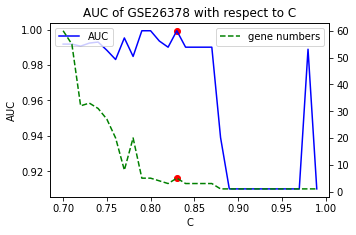

In [38]:
c = np.array(record["C"])
num_genes = np.array(record["num_genes"])
auc_curve = np.array(record["26378"])

fig = plt.figure(figsize=(5,3.2))
ax1 = fig.add_subplot(111)
ax1.plot(c,auc_curve,label="AUC",c='b')
ax1.scatter(0.83,auc_curve[13],c='r')
ax1.legend(loc=2)
#plt.plot(c,np.max(auc_curve)+np.zeros(c.shape),c='blue',linestyle=':')
ax1.set_xlabel("C")
ax1.set_ylabel("AUC")
ax2 = ax1.twinx()
ax2.plot(c,num_genes,label = "gene numbers",c='g',linestyle="--")
#ax2.plot([0.83,0.83],[5,60],c='black',linestyle=':')
ax2.scatter(0.83,num_genes[13],c='r')
ax2.legend(loc=1)
plt.title("AUC of GSE26378 with respect to C")
plt.savefig("figure/s2.pdf")